In [40]:
import json
from sentence_transformers import SentenceTransformer, util
from typing import Dict, List, Any
import pandas as pd

from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Optional
from typing import Union, List, Dict


from langgraph.graph.message import add_messages
from pydantic import BaseModel
import ollama

#from langchain.chat_models import ChatOllama
from langchain_ollama import ChatOllama

In [6]:
class State(TypedDict):
    # Define your state fields here
    count: int
    message: str


class SQL_State(State):
    pass

In [7]:
def document_retrieval_node(state: State):
    return state  # Placeholder function that returns the state unchanged


In [63]:
from langgraph.graph import StateGraph, START, END

# Initialize the SQL subgraph
sql_builder = StateGraph(SQL_State)

# Add nodes to the SQL subgraph
sql_builder.add_node("Planner", lambda x: x)
sql_builder.add_node("Select Data", lambda x: x)
sql_builder.add_node("Generate SQL", lambda x: x)
sql_builder.add_node("Execute SQL", lambda x: x)

sql_builder.add_node("Response Generation", lambda x: x)

# Define the routing function based on planner's decision
def route_based_on_planner_sql(state: State):
    return state.get("next_action", "action_not_possible")

# Add edges to define the workflow
sql_builder.add_edge(START, "Planner")
sql_builder.add_conditional_edges(
    "Planner",
    route_based_on_planner_sql,
    {
        "Action Not Possible": "Response Generation",
        "Query Data": "Select Data",
    }
)
sql_builder.add_edge("Select Data", "Generate SQL")
sql_builder.add_edge("Generate SQL", "Execute SQL")

# Add conditional edge for retry logic
sql_builder.add_conditional_edges(
    "Execute SQL",
    lambda s: "Retry" if (s.get("error_flag") and s.get("retry_count", 0) < 2) else "Respond",
    {
        "Retry": "Generate SQL",
        "Respond": "Response Generation"
    }
)



sql_builder.add_edge("Response Generation", END)

# Compile the SQL subgraph
sql_agent_graph = sql_builder.compile()


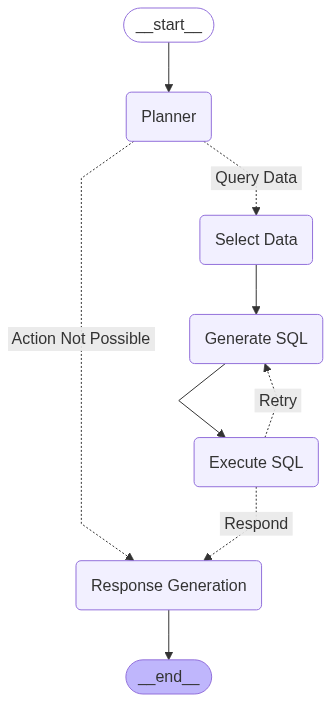

In [64]:
from IPython.display import Image

# Assuming 'graph' is your compiled LangGraph instance
Image(sql_agent_graph.get_graph().draw_mermaid_png())

In [48]:
# Initialize the main graph
graph_builder = StateGraph(State)

# Add nodes to the main graph
graph_builder.add_node("User Query Node", lambda x: x)
graph_builder.add_node("Planner", lambda x: x)
graph_builder.add_node("Invoke SQL Query", lambda x: x)  # Subgraph
graph_builder.add_node("Document Retrieval", lambda x: x)
graph_builder.add_node("Response Generation", lambda x: x)

# Define the routing function based on planner's decision
def route_based_on_planner(state: State):
    return state.get("next_action", "Answer Directly")

# Add conditional edges based on planner's output
graph_builder.add_conditional_edges(
    "Planner",
    route_based_on_planner,
    {
        "Use SQL Agent": "Invoke SQL Query",
        "Use Doc Retrieval": "Document Retrieval",
        "Answer Directly": "Response Generation"
    }
)

# Define the workflow
graph_builder.add_edge(START, "User Query Node")
graph_builder.set_entry_point("User Query Node")
graph_builder.add_edge("User Query Node", "Planner")
graph_builder.add_edge("Invoke SQL Query", "Response Generation")
graph_builder.add_edge("Document Retrieval", "Response Generation")
graph_builder.add_edge("Response Generation", END)

# Initialize memory for state persistence
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Compile the main graph with memory checkpointing
graph = graph_builder.compile(checkpointer=memory)

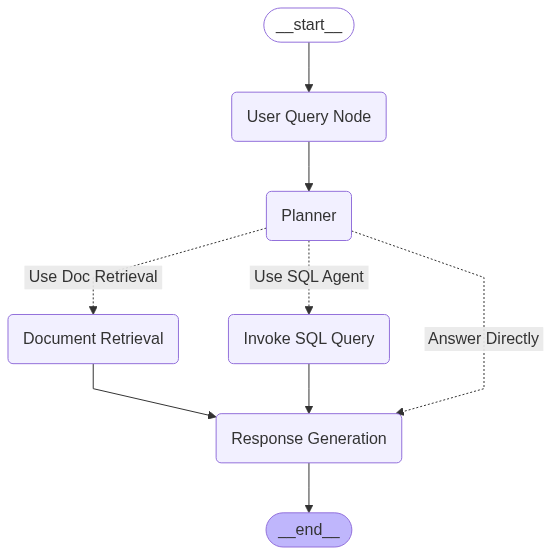

In [49]:
from IPython.display import Image

# Assuming 'graph' is your compiled LangGraph instance
Image(graph.get_graph().draw_mermaid_png())